In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# โหลดข้อมูล
df = pd.read_csv("data/bimts/bimts-5year.csv")

# ลบ unnamed columns
df = df.loc[:, ~df.columns.str.contains('unnamed', case=False)]

# Clean ขั้นพื้นฐาน (นี่แหละ df_clean)
df_clean = df[
    (df["UNIT_MEASURE"] == "USD_EXC") &
    (df["PRODUCT_TYPE"] == "C") &
    (df["OBS_VALUE"].notna())
].copy()

# ใช้ adjusted data เพื่อความสม่ำเสมอเชิงสถิติ
df_clean = df_clean[df_clean["ADJUSTMENT"] == "B_ADJ_RX"].copy()

df_clean.head()

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,COUNTERPART_AREA,TRADE_FLOW,PRODUCT_TYPE,PRODUCT_CPA,PRODUCT_HS,FREQ,UNIT_MEASURE,ADJUSTMENT,TIME_PERIOD,OBS_VALUE,OBS_STATUS,METHODOLOGY_TYPE,UNIT_MULT,DECIMALS
0,DATAFLOW,OECD.SDD.TPS:DSD_BIMTS@DF_BIMTS_CPA_2_1(1.0),NaN,I,VNM,THA,X,C,_T,_Z,A,USD_EXC,B_ADJ_RX,2021,6515.885962,E,AG,6,2
2,DATAFLOW,OECD.SDD.TPS:DSD_BIMTS@DF_BIMTS_CPA_2_1(1.0),NaN,I,VNM,TGO,X,C,_T,_Z,A,USD_EXC,B_ADJ_RX,2021,158.800632,E,AG,6,2
4,DATAFLOW,OECD.SDD.TPS:DSD_BIMTS@DF_BIMTS_CPA_2_1(1.0),NaN,I,VNM,URY,X,C,_T,_Z,A,USD_EXC,B_ADJ_RX,2021,80.280088,E,AG,6,2
6,DATAFLOW,OECD.SDD.TPS:DSD_BIMTS@DF_BIMTS_CPA_2_1(1.0),NaN,I,VNM,ZWE,X,C,_T,_Z,A,USD_EXC,B_ADJ_RX,2021,0.111343,E,AG,6,2
8,DATAFLOW,OECD.SDD.TPS:DSD_BIMTS@DF_BIMTS_CPA_2_1(1.0),NaN,I,VNM,YEM,X,C,_T,_Z,A,USD_EXC,B_ADJ_RX,2021,2.380840,E,AG,6,2


In [36]:
# ================================
# ONE CELL: DIAGNOSE + AUTO-RELAX THRESHOLDS IF EMPTY
# ================================
# 0) quick checks
print("rt rows:", len(rt))
print("unique regimes:", rt["regime"].dropna().unique()[:10], " ... count =", rt["regime"].nunique(dropna=True))
print("regime_next NaN ratio:", rt["regime_next"].isna().mean())
print("routes:", rt["route_id"].nunique(), " | years range:", rt["year"].min(), "-", rt["year"].max())

# 1) count routes by n_years
route_years = rt.groupby("route_id")["year"].nunique()
print("share routes with <=1 year:", (route_years<=1).mean(), "| <=2 years:", (route_years<=2).mean())

# 2) build stability quickly (same logic as before, no apply)
rt2 = rt.sort_values(["route_id","year"]).copy()

stability = (
    rt2.groupby("route_id", as_index=False)
       .agg(
            n_years=("year","nunique"),
            last_year=("year","max"),
            avg_risk=("risk_signal","mean"),
            share_high=("regime", lambda s: (s == "HIGH").mean()),
       )
)

tmp = rt2.dropna(subset=["regime","regime_next"]).copy()
p_l2h = (
    tmp.assign(is_l2h=((tmp["regime"]=="LOW") & (tmp["regime_next"]=="HIGH")).astype(int),
               is_low=(tmp["regime"]=="LOW").astype(int))
       .groupby("route_id", as_index=False)[["is_l2h","is_low"]].sum()
)
p_l2h["p_low_to_high"] = np.where(p_l2h["is_low"]>0, p_l2h["is_l2h"]/p_l2h["is_low"], 0.0)

stability = stability.merge(p_l2h[["route_id","p_low_to_high"]], on="route_id", how="left")
stability["p_low_to_high"] = stability["p_low_to_high"].fillna(0.0)

# filter
stability = stability.query("n_years >= 3").copy()

# 3) classify with default thresholds
def classify(df, high_thr=0.15, l2h_thr=0.10, pers_thr=0.35):
    out = df.copy()
    out["risk_class"] = np.select(
        [
            (out["share_high"] < high_thr) & (out["p_low_to_high"] < l2h_thr),
            (out["share_high"] < high_thr) & (out["p_low_to_high"] >= l2h_thr),
            (out["share_high"] >= pers_thr),
        ],
        ["STABLE_TRUE","STABLE_TEMP","PERSISTENT_RISK"],
        default="OTHER"
    )
    out["fragility_score"] = 0.6*out["p_low_to_high"] + 0.4*out["share_high"]
    return out

st0 = classify(stability)
print("\nclass counts (default):")
print(st0["risk_class"].value_counts(dropna=False))

# 4) if no STABLE_TEMP -> auto-relax thresholds
if (st0["risk_class"]=="STABLE_TEMP").sum() == 0:
    # relax l2h_thr down and/or high_thr up until we get some
    candidates = []
    for high_thr in [0.15, 0.20, 0.25]:
        for l2h_thr in [0.10, 0.08, 0.06, 0.05, 0.04, 0.03]:
            stx = classify(stability, high_thr=high_thr, l2h_thr=l2h_thr)
            cnt = (stx["risk_class"]=="STABLE_TEMP").sum()
            if cnt > 0:
                candidates.append((cnt, high_thr, l2h_thr, stx))
    if candidates:
        candidates.sort(key=lambda x: (-x[0], x[1], -x[2]))
        cnt, high_thr, l2h_thr, st1 = candidates[0]
        print(f"\nAUTO-RELAX applied -> got STABLE_TEMP={cnt} using high_thr={high_thr}, l2h_thr={l2h_thr}")
    else:
        st1 = st0
        print("\nAUTO-RELAX failed: still no STABLE_TEMP. Likely regime labels not LOW/HIGH or routes too short.")
else:
    st1 = st0

# 5) show top routes in each class (so you see something immediately)
def top(df, label, n=10):
    sub = df[df["risk_class"]==label].sort_values("fragility_score", ascending=False).head(n)
    print(f"\nTop {label} (n={len(sub)}):")
    display(sub[["route_id","n_years","share_high","p_low_to_high","fragility_score","avg_risk"]])

top(st1, "STABLE_TEMP", 10)
top(st1, "PERSISTENT_RISK", 10)
top(st1, "STABLE_TRUE", 10)

rt rows: 15004
unique regimes: ['LOW' 'MID' 'HIGH']  ... count = 3
regime_next NaN ratio: 0.16962143428419088
routes: 2545  | years range: 2018 - 2023
share routes with <=1 year: 0.005893909626719057 | <=2 years: 0.011394891944990177

class counts (default):
risk_class
PERSISTENT_RISK    1047
OTHER               804
STABLE_TRUE         665
Name: count, dtype: int64

AUTO-RELAX applied -> got STABLE_TEMP=97 using high_thr=0.2, l2h_thr=0.1

Top STABLE_TEMP (n=10):


,route_id,n_years,share_high,p_low_to_high,fragility_score,avg_risk
99,AUS_LBN_X,6,0.166667,0.5,0.366667,-0.208885
1822,SGP_FRA_X,6,0.166667,0.5,0.366667,-0.292112
861,IDN_KWT_X,6,0.166667,0.5,0.366667,-0.284834
917,IDN_RWA_X,6,0.166667,0.5,0.366667,0.184106
956,IDN_WSM_X,6,0.166667,0.5,0.366667,-0.277135
1041,IND_HTI_X,6,0.166667,0.5,0.366667,-0.270733
133,AUS_NOR_X,6,0.166667,0.5,0.366667,-0.265378
1256,JPN_KHM_X,6,0.166667,0.5,0.366667,-0.311047
1549,KOR_UZB_X,6,0.166667,0.5,0.366667,-0.310497
1582,MYS_BLR_X,6,0.166667,0.5,0.366667,-0.146940



Top PERSISTENT_RISK (n=10):


,route_id,n_years,share_high,p_low_to_high,fragility_score,avg_risk
2543,VNM_ZMB_X,6,0.833333,1.0,0.933333,0.454469
1762,SGP_ABW_X,6,0.833333,1.0,0.933333,1.164617
1752,MYS_VEN_X,6,0.833333,1.0,0.933333,0.138651
1738,MYS_TLS_X,6,0.833333,1.0,0.933333,0.183403
1736,MYS_TJK_X,6,0.833333,1.0,0.933333,0.748612
1734,MYS_TGO_X,6,0.833333,1.0,0.933333,0.519171
427,FRA_BTN_X,6,0.833333,1.0,0.933333,2.677808
428,FRA_BWA_X,6,0.833333,1.0,0.933333,0.818341
1730,MYS_SWZ_X,6,0.833333,1.0,0.933333,0.361360
1722,MYS_SLV_X,6,0.833333,1.0,0.933333,0.049106



Top STABLE_TRUE (n=10):


,route_id,n_years,share_high,p_low_to_high,fragility_score,avg_risk
2033,THA_GRD_X,6,0.166667,0.0,0.066667,-0.254383
1956,SGP_WXD_X,6,0.166667,0.0,0.066667,-0.276375
1013,IND_DOM_X,6,0.166667,0.0,0.066667,-0.293320
1012,IND_DNK_X,6,0.166667,0.0,0.066667,-0.298951
1008,IND_CZE_X,6,0.166667,0.0,0.066667,-0.330410
1947,SGP_UKR_X,6,0.166667,0.0,0.066667,-0.303199
1000,IND_COD_X,6,0.166667,0.0,0.066667,-0.246773
999,IND_CMR_X,6,0.166667,0.0,0.066667,-0.311880
998,IND_CIV_X,6,0.166667,0.0,0.066667,-0.318591
997,IND_CHN_X,6,0.166667,0.0,0.066667,-0.278990


In [41]:
tiva_raw = pd.read_csv("data/tiva/EXGR_DVA.csv")

# ---- 1) filter Thailand + (World aggregate if exists) ----
t = tiva_raw.copy()
t["REF_AREA"] = t["REF_AREA"].astype(str).str.upper()
t["COUNTERPART_AREA"] = t["COUNTERPART_AREA"].astype(str).str.upper()

t = t[t["REF_AREA"] == "THA"].copy()

# ถ้ามี WLD ให้ใช้ WLD ก่อน (TiVA บางไฟล์มี counterpart)
if "COUNTERPART_AREA" in t.columns:
    if (t["COUNTERPART_AREA"] == "WLD").any():
        t = t[t["COUNTERPART_AREA"] == "WLD"].copy()

# ---- 2) สรุป coverage ต่อ ACTIVITY เพื่อเลือก Total economy แบบ heuristic ----
t["TIME_PERIOD"] = pd.to_numeric(t["TIME_PERIOD"], errors="coerce")
t["OBS_VALUE"] = pd.to_numeric(t["OBS_VALUE"], errors="coerce")

act_stats = (
    t.dropna(subset=["TIME_PERIOD", "OBS_VALUE"])
     .groupby("ACTIVITY", as_index=False)
     .agg(
         n_years=("TIME_PERIOD", "nunique"),
         year_min=("TIME_PERIOD", "min"),
         year_max=("TIME_PERIOD", "max"),
         total_value=("OBS_VALUE", "sum"),
         avg_value=("OBS_VALUE", "mean")
     )
     .sort_values(["n_years", "total_value"], ascending=[False, False])
)

print("Top ACTIVITY candidates (first 15):")
display(act_stats.head(15))

# เลือก ACTIVITY ที่น่าจะเป็น TOTAL: ครอบคลุมปีมากสุด + มูลค่ารวมมากสุด
best_act = act_stats.iloc[0]["ACTIVITY"]
print("Selected ACTIVITY =", best_act)

# ---- 3) สร้าง tiva_tha (year, dva_total) ----
tiva_tha = (
    t[t["ACTIVITY"] == best_act]
      .rename(columns={"TIME_PERIOD": "year", "OBS_VALUE": "dva_total"})[["year", "dva_total"]]
      .dropna()
      .sort_values("year")
      .reset_index(drop=True)
)

print("tiva_tha head:")
display(tiva_tha.head(10))

Top ACTIVITY candidates (first 15):


,ACTIVITY,n_years,year_min,year_max,total_value,avg_value
78,_T,28,1995,2022,2.078082e+07,7496.688424
13,BTE,28,1995,2022,1.297097e+07,4679.283526
14,C,28,1995,2022,1.283795e+07,4631.295646
46,FTT,28,1995,2022,7.204146e+06,2598.898448
50,GTT,28,1995,2022,7.204079e+06,2598.874265
49,GTN,28,1995,2022,6.862195e+06,2475.539407
48,GTI,28,1995,2022,5.440666e+06,1962.722381
33,C26_27,28,1995,2022,3.008686e+06,1085.384652
47,G,28,1995,2022,2.963806e+06,1069.194262
21,C19T23,28,1995,2022,2.879034e+06,1038.612448


Selected ACTIVITY = _T
tiva_tha head:


,year,dva_total
0,1995,16.830
1,1995,14690.844
2,1995,7.418
3,1995,34796.628
4,1995,16.188
5,1995,2765.255
6,1995,55.783
7,1995,296.137
8,1995,5.251
9,1995,401.520


In [44]:
# =========================
# FIX TiVA: Aggregate TOTAL economy (_T) to 1 value per year
# =========================
# ใช้ dataframe t ที่มีอยู่แล้ว (filtered THA + WLD + ACTIVITY=_T)
# ensure numeric
t["_year"] = pd.to_numeric(t["TIME_PERIOD"], errors="coerce")
t["_val"] = pd.to_numeric(t["OBS_VALUE"], errors="coerce")

# keep only ACTIVITY = _T (Total economy)
t_tot = t[t["ACTIVITY"] == "_T"].copy()

# aggregate to 1 DVA per year
tiva_tha = (
    t_tot
    .groupby("_year", as_index=False)["_val"]
    .sum()
    .rename(columns={"_year": "year", "_val": "dva_total"})
    .sort_values("year")
    .reset_index(drop=True)
)

tiva_tha

,year,dva_total
0,1995,324692.939
1,1996,331135.003
2,1997,320974.772
3,1998,293916.179
4,1999,310918.672
5,2000,326901.488
6,2001,299826.181
7,2002,326855.629
8,2003,375060.112
9,2004,440284.910


In [47]:
# =========================
# STEP 2 (ROBUST): TiVA DVA → allocate to partners using BIMTS shares → Systemic Risk
# Works even if rt has NO 'flow' column
# =========================

# 1) Align TiVA years (TiVA ends 2022)
tiva_use = tiva_tha.query("year >= 2018 and year <= 2022").copy()

# 2) Prepare rt
rt2 = rt.copy()

# ensure year numeric
if "year" not in rt2.columns:
    raise ValueError("rt must contain 'year' column. If your column is TIME_PERIOD, rename it to 'year' first.")

rt2["year"] = pd.to_numeric(rt2["year"], errors="coerce").astype("Int64")

# ensure trade_value column name
if "trade_value" not in rt2.columns:
    if "OBS_VALUE" in rt2.columns:
        rt2 = rt2.rename(columns={"OBS_VALUE": "trade_value"})
    else:
        raise ValueError("rt must contain 'trade_value' (or OBS_VALUE).")

# ensure route_id exists
if "route_id" not in rt2.columns:
    # try build it from reporter/partner/flow if present
    cand_reporter = "reporter" if "reporter" in rt2.columns else ("REF_AREA" if "REF_AREA" in rt2.columns else None)
    cand_partner  = "partner"  if "partner"  in rt2.columns else ("COUNTERPART_AREA" if "COUNTERPART_AREA" in rt2.columns else None)
    cand_flow     = "flow"     if "flow"     in rt2.columns else ("TRADE_FLOW" if "TRADE_FLOW" in rt2.columns else None)
    if None in [cand_reporter, cand_partner, cand_flow]:
        raise ValueError("rt has no route_id and not enough columns to build it (need reporter/partner/flow).")
    rt2["route_id"] = (
        rt2[cand_reporter].astype(str).str.upper() + "_" +
        rt2[cand_partner].astype(str).str.upper() + "_" +
        rt2[cand_flow].astype(str).str.upper()
    )

# 3) Extract reporter/partner/flow safely from route_id (always works)
rid_parts = rt2["route_id"].astype(str).str.rsplit("_", n=2, expand=True)
rt2["reporter"] = rid_parts[0].astype(str).str.upper()
rt2["partner"]  = rid_parts[1].astype(str).str.upper()
rt2["flow"]     = rid_parts[2].astype(str).str.upper()

# 4) THA exports only (flow == X)
tha_x = rt2[(rt2["reporter"] == "THA") & (rt2["flow"] == "X")].copy()

# 5) partner-year export share
exp_partner = tha_x.groupby(["year","partner"], as_index=False)["trade_value"].sum()

exp_total = (
    exp_partner.groupby("year", as_index=False)["trade_value"].sum()
              .rename(columns={"trade_value":"exp_total"})
)

exp_partner = exp_partner.merge(exp_total, on="year", how="left")
exp_partner["partner_share"] = exp_partner["trade_value"] / exp_partner["exp_total"].replace(0, np.nan)

# 6) Allocate DVA to partners
exp_partner = exp_partner.merge(tiva_use, on="year", how="inner")
exp_partner["dva_partner"] = exp_partner["dva_total"] * exp_partner["partner_share"]

# 7) Join with fragility (priority from Step 1)
frag = priority[["route_id","risk_class","fragility_score"]].copy()

# parse partner from route_id
fparts = frag["route_id"].astype(str).str.rsplit("_", n=2, expand=True)
frag["reporter"] = fparts[0].astype(str).str.upper()
frag["partner"]  = fparts[1].astype(str).str.upper()
frag["flow"]     = fparts[2].astype(str).str.upper()

# keep THA exports only (align with DVA Thailand)
frag = frag[(frag["reporter"]=="THA") & (frag["flow"]=="X")].copy()

# 8) Build route-year DVA and systemic score (use latest common year = 2022)
route_va = frag.merge(exp_partner[["year","partner","dva_partner"]], on="partner", how="left")

latest_year = int(route_va["year"].max())  # should be 2022
route_va_latest = route_va[route_va["year"] == latest_year].copy()

route_va_latest["systemic_score"] = route_va_latest["fragility_score"] * route_va_latest["dva_partner"]

top_systemic = (
    route_va_latest.dropna(subset=["dva_partner","systemic_score"])
      .sort_values("systemic_score", ascending=False)
      .head(20)
)

top_systemic[["route_id","partner","risk_class","fragility_score","dva_partner","systemic_score"]]

,route_id,partner,risk_class,fragility_score,dva_partner,systemic_score
164,THA_CHE_X,CHE,PERSISTENT_RISK,0.933333,6659.458134,6215.494259
409,THA_IND_X,IND,OTHER,0.133333,20318.172809,2709.089708
304,THA_FRA_X,FRA,OTHER,0.433333,4042.934853,1751.938436
639,THA_MYS_X,MYS,OTHER,0.066667,23539.895887,1569.326392
714,THA_PHL_X,PHL,OTHER,0.066667,14680.666760,978.711117
474,THA_KHM_X,KHM,OTHER,0.066667,14071.694182,938.112945
84,THA_BGD_X,BGD,OTHER,0.266667,2249.134513,599.769203
434,THA_ISR_X,ISR,OTHER,0.433333,1383.182694,599.379168
699,THA_PAK_X,PAK,PERSISTENT_RISK,0.200000,2639.743076,527.948615
424,THA_IRQ_X,IRQ,PERSISTENT_RISK,0.266667,1954.167752,521.111401


In [48]:
df = route_va_latest.copy()

# 0) Basic cleaning
df = df.dropna(subset=["dva_partner","fragility_score"]).copy()
df["systemic_score"] = df["fragility_score"] * df["dva_partner"]

# 1) Risk–VA Matrix (4 quadrants using medians)
frag_med = df["fragility_score"].median()
dva_med  = df["dva_partner"].median()

df["frag_bin"] = np.where(df["fragility_score"] >= frag_med, "High Fragility", "Low Fragility")
df["dva_bin"]  = np.where(df["dva_partner"] >= dva_med, "High DVA", "Low DVA")
df["quadrant"] = df["frag_bin"] + " × " + df["dva_bin"]

matrix = (
    df.groupby("quadrant", as_index=False)
      .agg(
          n_routes=("route_id","count"),
          total_dva=("dva_partner","sum"),
          total_systemic=("systemic_score","sum"),
          avg_frag=("fragility_score","mean")
      )
      .sort_values("total_systemic", ascending=False)
)

print("=== Risk–VA Matrix (latest year) ===")
display(matrix)

# 2) Top systemic routes overall
top_systemic_20 = df.sort_values("systemic_score", ascending=False).head(20)
print("=== Top 20 Systemic Routes ===")
display(top_systemic_20[["route_id","partner","risk_class","fragility_score","dva_partner","systemic_score"]])

# 3) Hidden systemic: STABLE_TEMP (นิ่งหลอก) ที่ systemic สูง
hidden = df[df["risk_class"] == "STABLE_TEMP"].sort_values("systemic_score", ascending=False).head(20)
print("=== Hidden Systemic (STABLE_TEMP) Top 20 ===")
display(hidden[["route_id","partner","risk_class","fragility_score","dva_partner","systemic_score"]])

# 4) Policy simulation: shift alpha% of DVA out of risky group into STABLE_TRUE (proportional)
def simulate_shift(alpha=0.10, risky_classes=("PERSISTENT_RISK","STABLE_TEMP"), target_class="STABLE_TRUE"):
    sim = df.copy()
    risky = sim["risk_class"].isin(risky_classes)
    safe  = sim["risk_class"].eq(target_class)

    # total DVA to move
    move_total = sim.loc[risky, "dva_partner"].sum() * alpha
    if move_total <= 0 or sim.loc[safe, "dva_partner"].sum() <= 0:
        return None

    # subtract from risky proportional to their DVA
    risky_weights = sim.loc[risky, "dva_partner"] / sim.loc[risky, "dva_partner"].sum()
    sim.loc[risky, "dva_partner_adj"] = sim.loc[risky, "dva_partner"] - move_total * risky_weights

    # add to safe proportional to their current DVA
    safe_weights = sim.loc[safe, "dva_partner"] / sim.loc[safe, "dva_partner"].sum()
    sim.loc[safe, "dva_partner_adj"] = sim.loc[safe, "dva_partner"] + move_total * safe_weights

    # others unchanged
    other = ~(risky | safe)
    sim.loc[other, "dva_partner_adj"] = sim.loc[other, "dva_partner"]

    # compute systemic before/after
    sim["systemic_before"] = sim["fragility_score"] * sim["dva_partner"]
    sim["systemic_after"]  = sim["fragility_score"] * sim["dva_partner_adj"]

    before = sim["systemic_before"].sum()
    after  = sim["systemic_after"].sum()

    return {
        "alpha": alpha,
        "before_total_systemic": before,
        "after_total_systemic": after,
        "reduction_abs": before - after,
        "reduction_pct": (before - after) / before if before > 0 else np.nan
    }

sim10 = simulate_shift(0.10)
sim20 = simulate_shift(0.20)

print("=== Policy Simulation (shift DVA out of PERSISTENT_RISK + STABLE_TEMP into STABLE_TRUE) ===")
display(pd.DataFrame([sim10, sim20]))

=== Risk–VA Matrix (latest year) ===


,quadrant,n_routes,total_dva,total_systemic,avg_frag
0,High Fragility × High DVA,37,5.460372e+04,16501.970683,0.297297
2,Low Fragility × High DVA,63,1.136564e+06,5153.645272,0.014815
1,High Fragility × Low DVA,71,2.354825e+03,759.370812,0.393474
3,Low Fragility × Low DVA,29,1.190328e+03,22.350545,0.025287


=== Top 20 Systemic Routes ===


,route_id,partner,risk_class,fragility_score,dva_partner,systemic_score
164,THA_CHE_X,CHE,PERSISTENT_RISK,0.933333,6659.458134,6215.494259
409,THA_IND_X,IND,OTHER,0.133333,20318.172809,2709.089708
304,THA_FRA_X,FRA,OTHER,0.433333,4042.934853,1751.938436
639,THA_MYS_X,MYS,OTHER,0.066667,23539.895887,1569.326392
714,THA_PHL_X,PHL,OTHER,0.066667,14680.666760,978.711117
474,THA_KHM_X,KHM,OTHER,0.066667,14071.694182,938.112945
84,THA_BGD_X,BGD,OTHER,0.266667,2249.134513,599.769203
434,THA_ISR_X,ISR,OTHER,0.433333,1383.182694,599.379168
699,THA_PAK_X,PAK,PERSISTENT_RISK,0.200000,2639.743076,527.948615
424,THA_IRQ_X,IRQ,PERSISTENT_RISK,0.266667,1954.167752,521.111401


=== Hidden Systemic (STABLE_TEMP) Top 20 ===


,route_id,partner,risk_class,fragility_score,dva_partner,systemic_score


=== Policy Simulation (shift DVA out of PERSISTENT_RISK + STABLE_TEMP into STABLE_TRUE) ===


,alpha,before_total_systemic,after_total_systemic,reduction_abs,reduction_pct
0,0.1,22437.337313,21559.634389,877.702924,0.039118
1,0.2,22437.337313,20681.931464,1755.405848,0.078236


Saved: fig_fragility_vs_dva_quadrants_journal.png
Saved: fig_fragility_vs_dva_quadrants_journal.pdf


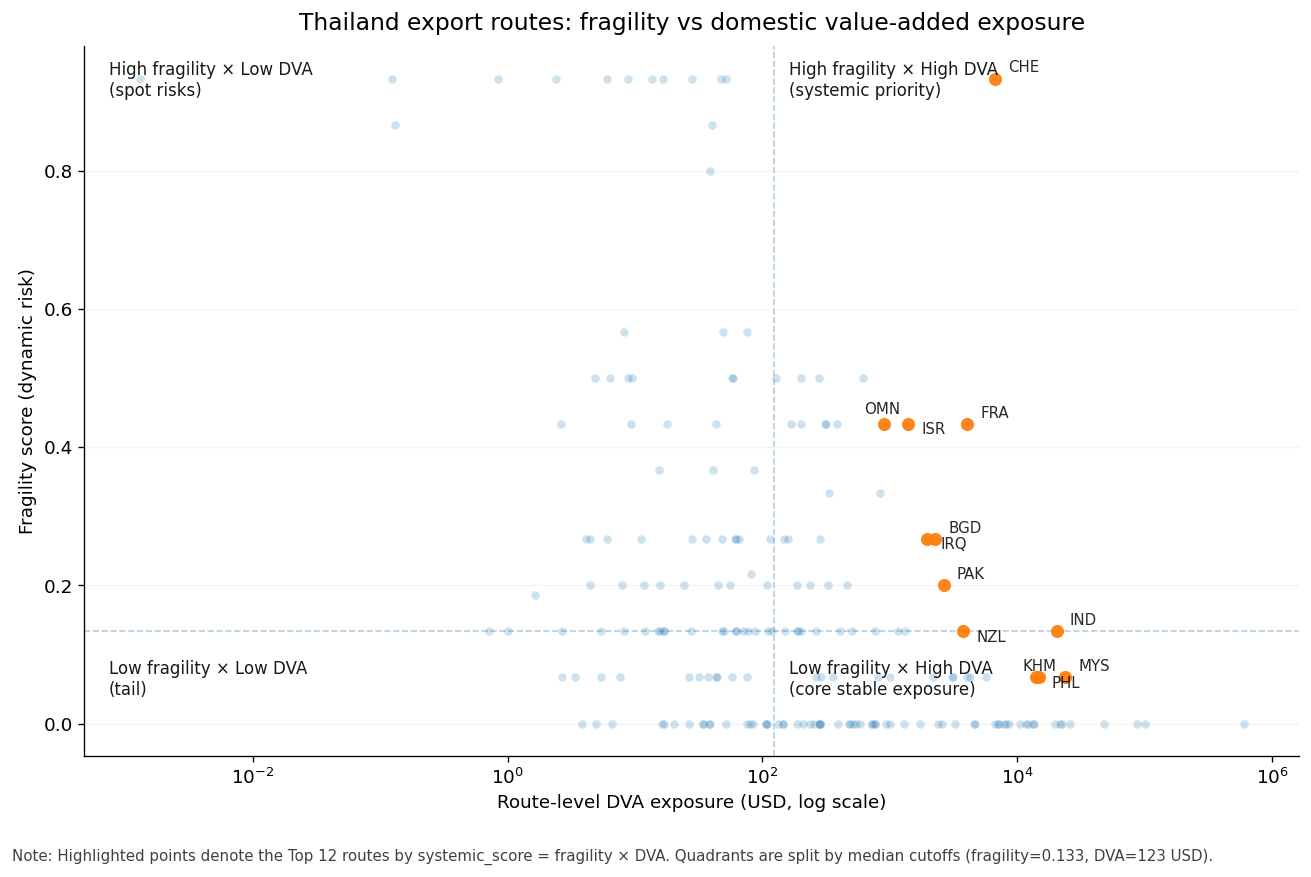

In [55]:
# =========================
# - clean background
# - highlight TopN systemic routes
# - non-overlapping labels (greedy)
# - subtle quadrant lines + quadrant captions
# - export PNG + vector PDF
# =========================

# ---------- Helpers ----------
def _apply_journal_style():
    plt.rcParams.update({
        "font.size": 11,
        "axes.titlesize": 14,
        "axes.labelsize": 11,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titlepad": 10,
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "pdf.fonttype": 42,  # better embedding
        "ps.fonttype": 42,
    })

import numpy as np
import matplotlib.ticker as mticker

def _setup_log_x(ax):
    ax.set_xscale("log")
    ax.xaxis.set_major_locator(mticker.LogLocator(base=10))
    ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())

def _overlap_area(a, b):
    # a,b: (x0,y0,x1,y1) in display coords
    dx = min(a[2], b[2]) - max(a[0], b[0])
    dy = min(a[3], b[3]) - max(a[1], b[1])
    return max(0, dx) * max(0, dy)

def _greedy_label_placer(ax, xs, ys, labels, fontsize=8, max_tries=36, alpha=0.85):
    """
    Greedy label placement using REAL text extents (renderer-based).
    - Tries many offsets
    - Accepts first non-overlapping placement
    - If unavoidable, chooses placement with minimal total overlap area
    """
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    # Offsets in points (more variety, but bounded)
    candidates = [
        (8, 4), (8, -6), (-8, 4), (-8, -6),
        (0, 9), (0, -10), (10, 0), (-10, 0),
        (12, 6), (12, -8), (-12, 6), (-12, -8),
        (16, 2), (16, -4), (-16, 2), (-16, -4),
        (6, 12), (6, -14), (-6, 12), (-6, -14),
        (20, 8), (20, -10), (-20, 8), (-20, -10),
        (0, 14), (0, -16), (24, 0), (-24, 0),
    ]
    if max_tries > len(candidates):
        max_tries = len(candidates)

    placed_boxes = []

    for x, y, lab in zip(xs, ys, labels):
        lab = str(lab)

        best = None
        best_cost = float("inf")

        # Try offsets; compute true bbox after rendering
        for dx, dy in candidates[:max_tries]:
            # create a temporary invisible annotation to measure bbox
            ann = ax.annotate(
                lab,
                (float(x), float(y)),
                textcoords="offset points",
                xytext=(dx, dy),
                fontsize=fontsize,
                alpha=alpha,
                zorder=5,
                visible=True,
            )
            fig.canvas.draw()
            bbox = ann.get_window_extent(renderer=renderer).expanded(1.02, 1.10)  # small padding
            box = (bbox.x0, bbox.y0, bbox.x1, bbox.y1)

            # compute overlap cost against already placed
            cost = 0.0
            for b in placed_boxes:
                cost += _overlap_area(box, b)

            # remove temp annotation (we will re-add final)
            ann.remove()

            # perfect placement: no overlap
            if cost == 0:
                best = (dx, dy, box)
                best_cost = 0
                break

            # keep least-overlap option
            if cost < best_cost:
                best = (dx, dy, box)
                best_cost = cost

        # Place final chosen annotation
        dx, dy, box = best
        ax.annotate(
            lab,
            (float(x), float(y)),
            textcoords="offset points",
            xytext=(dx, dy),
            fontsize=fontsize,
            alpha=alpha,
            zorder=5,
        )
        placed_boxes.append(box)


# ---------- Main ----------
_apply_journal_style()

df = route_va_latest.copy()
df = df.dropna(subset=["fragility_score", "dva_partner"]).copy()
df["fragility_score"] = df["fragility_score"].astype(float)
df["dva_partner"] = df["dva_partner"].astype(float)
df["systemic_score"] = df["fragility_score"] * df["dva_partner"]

# Quadrant splits (median; robust)
frag_cut = float(df["fragility_score"].median())
dva_cut  = float(df["dva_partner"].median())

use_logx = True
topN = 12

fig, ax = plt.subplots(figsize=(11, 7))

# Background points (quiet)
ax.scatter(
    df["dva_partner"].values,
    df["fragility_score"].values,
    s=26,
    alpha=0.22,
    linewidths=0,
    zorder=1,
)

# Highlight points (single emphasis)
top = df.sort_values("systemic_score", ascending=False).head(topN)
ax.scatter(
    top["dva_partner"].values,
    top["fragility_score"].values,
    s=62,
    alpha=0.95,
    linewidths=0,
    zorder=3,
)

# Quadrant lines (subtle)
ax.axhline(frag_cut, linewidth=1.0, alpha=0.35, linestyle="--", zorder=2)
ax.axvline(dva_cut,  linewidth=1.0, alpha=0.35, linestyle="--", zorder=2)

# Labels (non-overlapping, greedy)
_greedy_label_placer(
    ax,
    xs=top["dva_partner"].values,
    ys=top["fragility_score"].values,
    labels=top["partner"].astype(str).values,
    fontsize=9,
)

# Axes
if use_logx:
    _setup_log_x(ax)
    xlabel = "Route-level DVA exposure (USD, log scale)"
else:
    xlabel = "Route-level DVA exposure (USD)"

ax.set_xlabel(xlabel)
ax.set_ylabel("Fragility score (dynamic risk)")

# Light grid: y only
ax.grid(True, axis="y", which="major", linewidth=0.8, alpha=0.15)
ax.grid(False, axis="x")

# Quadrant captions (short, reviewer-friendly)
ax.text(0.02, 0.98, "High fragility × Low DVA\n(spot risks)",
        transform=ax.transAxes, va="top", ha="left", fontsize=10, alpha=0.9)
ax.text(0.58, 0.98, "High fragility × High DVA\n(systemic priority)",
        transform=ax.transAxes, va="top", ha="left", fontsize=10, alpha=0.9)
ax.text(0.02, 0.08, "Low fragility × Low DVA\n(tail)",
        transform=ax.transAxes, va="bottom", ha="left", fontsize=10, alpha=0.9)
ax.text(0.58, 0.08, "Low fragility × High DVA\n(core stable exposure)",
        transform=ax.transAxes, va="bottom", ha="left", fontsize=10, alpha=0.9)

# Title (technical; keep message in caption)
ax.set_title("Thailand export routes: fragility vs domestic value-added exposure")

# Figure note (caption-like, below plot)
note = (
    f"Note: Highlighted points denote the Top {topN} routes by systemic_score = fragility × DVA. "
    f"Quadrants are split by median cutoffs (fragility={frag_cut:.3f}, DVA={dva_cut:,.0f} USD)."
)
fig.text(0.01, -0.02, note, ha="left", va="top", fontsize=9, alpha=0.75)

fig.tight_layout()

# Export: PNG + vector PDF (preferred for journal)
out_png = "fig_fragility_vs_dva_quadrants_journal.png"
out_pdf = "fig_fragility_vs_dva_quadrants_journal.pdf"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
print("Saved:", out_png)
print("Saved:", out_pdf)

plt.show()